# Affective Computing - Openface EDA
## Ryan Jenkinson

This notebook will serve to understand the OpenFace Data a bit more, and perform some Exploratory Data Analysis (EDA) that we can use for preprocessing the data before we test some models.

## Connect to Drive and Colab for dependencies

In [0]:
# Get the Empatica Features from our Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# Clone github repo
!git clone https://github.com/RyanJenkinson/clide.git

fatal: destination path 'clide' already exists and is not an empty directory.


## Import modules for basic functionality

In [0]:
# Import dependencies
import numpy as np
import scipy as sp
# I was getting a pickle error and needed to upgrade pandas on colab
!pip install --upgrade pandas
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [0]:
with open('clide/data/processed_data/list_of_dfs.pickle', 'rb') as file:
    list_of_dfs = pickle.load(file)
    
# Get number of people    
NUM_PERSONS = len(np.unique(pd.concat(list_of_dfs)['Person ID']))
# Look at all dataframes
df_all = pd.concat(list_of_dfs).drop(columns=['frame','face_id','timestamp',
                                              'confidence','Person ID',
                                              'question','success'])    
    
# In case we want to work with an example dataframe
df = list_of_dfs[0]
df.drop(columns=['frame','face_id','timestamp','confidence'], inplace=True)

## Data visualisation to see any relationships between features

In [0]:
features = df_all.select_dtypes(include=[np.number]).columns.tolist()
features = features[1:] # Remove the label
linregress_df = pd.DataFrame(columns=['Feature','r_value','std_error'])
row_count = np.floor(np.sqrt(len(features)))
col_count = np.ceil(len(features) / row_count)
# Manually chosen constant to multiply the figsize by so plt.tight_layout works
figure = plt.figure(figsize=(4*row_count,4*col_count))

for index, feature in enumerate(features):
  figure.add_subplot(row_count, col_count, index + 1)
  y = df_all[feature]
  x = df_all["label"]
  slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)
  linregress_df = linregress_df.append(pd.DataFrame({'Feature': feature,
                                                     'r_value': r_value,
                                                     'std_error': std_err}, 
                                                    index=[0]), 
                                       ignore_index = True) 
  sns.pointplot(x, slope * x + intercept, color='k',markersize='3',markers='x',
               linestyles='--')
  #plt.scatter(x, y)
  sns.boxplot(x="label", y=feature, data=df_all)
  plt.title("{0} vs. {1} - R value {2}".format(feature, "label",
                                               round(r_value,3)))
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Feature correlations in tabular form

In [0]:
linregress_df['R^2'] = linregress_df['r_value']**2
linregress_df.sort_values(by=['R^2'], ascending=False).head(10)
# As we can see, there is really not much correlation between 
# any particular variable alone and the target label ...

,Feature,r_value,std_error,R^2
651,p_11,-0.095140,0.093580,0.009052
693,AU04_c,-0.086866,0.004361,0.007546
696,AU07_c,-0.078874,0.005705,0.006221
677,AU05_r,0.069688,0.005007,0.004856
682,AU12_r,-0.058592,0.020674,0.003433
673,p_33,-0.057406,0.003950,0.003295
649,p_9,0.056524,0.144078,0.003195
678,AU06_r,-0.053673,0.015573,0.002881
636,p_ry,-0.053427,0.002498,0.002854
690,AU45_r,0.053063,0.017809,0.002816


For the next steps, we would want to look at the documentation, and start to craft/prune features that we think are relevant based on the literature/logic. We can continue looking at plots on reduced feature set sizes to try and get an understanding, but it is unlikely that all of these elements will help in a non deep learning approach, we would probably want to rely on handcrafted features more...

**TODO:**
* Subtract all geometrical points from the nose point
* Do we want to do aligned faces? Can't do it for Louise so maybe not best?
* Continue EDA and getting good plots

###  Define Preprocessing Functions

In [0]:
def preprocess_df(df_all, mode=0):
  ''' A function to preprocess the dataframe'''
  df_pp = df_all.copy() # Store df_pp as shorthand for df_preprocessed
  
  ##############################################################################
  #        To initialise, get a list of different features by category         #
  ##############################################################################
  face_features = [feature for feature in df_pp.columns.tolist()
                   if (feature.split("_")[0].lower() in ['x','y','z'])]
  gaze_features = [feature for feature in df_pp.columns.to_list()
                   if feature.split("_")[0] == 'gaze']
  eye_features = [feature for feature in df_pp.columns.to_list()
                  if feature.split("_")[0] == 'eye']
  pose_features = [feature for feature in df_pp.columns.to_list()
                   if feature.split("_")[0] == 'pose']
  # Get features from Point Distribution Model (PDM) that describe the rigid 
  # face shape (location, scale and rotation) and non-rigid face shape 
  # (deformation due to expression and identity)-see OpenFace Wiki for more info
  PDM_features = [feature for feature in df_pp.columns.to_list()
                  if feature.split("_")[0] == 'p']
  # Get Action Unit Features
  AU_features = [feature for feature in df_pp.columns.to_list()
                 if feature.split("_")[0][:2] == 'AU']
  
  ##############################################################################
  #      Get position landmarks on the face relative to the nose datapoint     #
  ##############################################################################
  # The nose datapoint is always _33. Get facial features relative to this point
  for feature in face_features:
    nose_feature = feature.split("_")[0] + "_33"
    df_pp[feature] -= df_pp[nose_feature]
    
  ##############################################################################    
  #               Get relative position landmarks for eyes                     #
  ##############################################################################
  #Features 1-27 are participant's right eye, 28-55 are their left eye. 
  #All features in the right eye are now relative to marker _25
  #All features in the left eye are now relative to marker _53
  for feature in eye_features:
    if int(feature.split("_")[-1]) < 28:
      split_list = feature.split("_")
      eye_feature = split_list[0] + "_" + split_list[1] + "_" + split_list[2] + "_25"  
    else:
      split_list = feature.split("_")
      eye_feature = split_list[0] + "_" + split_list[1] + "_" + split_list[2] + "_53"
    df_pp[feature] -= df_pp[eye_feature]
    
   # ANY MORE RELATIVE POSITIONING  TO BE DONE HERE?!
  
  ##############################################################################
  #    Remove unnecessary columns - including the nose and eye landmarks       #
  ##############################################################################
  nose_features = [feature for feature in face_features
                   if feature.split("_")[-1] == '33']
  eye1_features = [feature for feature in eye_features 
                   if feature.split("_")[-1] == '25']
  eye2_features = [feature for feature in eye_features 
                   if feature.split("_")[-1] == '53']
  cols_to_remove = nose_features + eye1_features + eye2_features #add others?

  df_pp.drop(columns=cols_to_remove, inplace=True)
  
  # Identify columns that we are going to keep, will depend on the mode we use!
  cols_to_keep = ['label']
  # Return different preprocessing modes
  if mode >= 0:
    # This is the most basic mode, that will just use the Action Unit features
    cols_to_keep += AU_features
  if mode >= 1:
    # This mode will additionally include pose features
    cols_to_keep += pose_features
  if mode >= 2:
    # This mode will additionally include gaze features
    cols_to_keep += gaze_features

  return df_pp[cols_to_keep]

def df_to_features(df_pp, mode=0, standardise=False):
  '''This function takes in a preprocessed dataframe and outputs a single fixed
  length vector including features that summarise the interaction'''
  # Ensure there is only 1 label for the interaction, as we want to process on 
  # an interaction by interaction basis
  assert len(np.unique(df_pp['label'])) == 1 
  label = np.unique(df_pp['label'])[0]
  df_pp.drop(columns=['label'], inplace=True)
  
  # When you come up with a new "wave" of ideas can you include the additional 
  # features under a new "mode" so that we can compare different modes in the 
  # analysis ! :) 
  col_names = df_pp.columns.tolist()
  categorical_features = [feature for feature in col_names
                          if feature.split("_")[-1] == 'c']#This will get AUXX_c
  regression_features = list(set(col_names) - set(categorical_features))
  
  if mode == 0:
    # Take a sum (count) of categorical AU's and a mean of the regression features
    feature_vec = pd.concat([df_pp[categorical_features]
                             .sum().add_suffix('_count'),
                             df_pp[regression_features]
                             .mean().add_suffix('_mean')])
  if mode == 1:
    # Same as mode 0 but additionally get standard deviation of regression features
    feature_vec = pd.concat([df_pp[categorical_features]
                             .sum().add_suffix('_count'),
                             df_pp[regression_features]
                             .mean().add_suffix('_mean'),
                             df_pp[regression_features]
                             .std().add_suffix('_std')])
  if mode == 2:
    # Same as mode 1 but split into 3 time chunks
    feature_vec = pd.concat(
        [df.sum().add_suffix('_count_' + str(i)) 
         for i,df in enumerate(np.array_split(df_pp[categorical_features],3))] + 
        [df.mean().add_suffix('_mean_' + str(i)) 
         for i,df in enumerate(np.array_split(df_pp[regression_features], 3))] + 
        [df.std().add_suffix('_std_' + str(i)) 
         for i,df in enumerate(np.array_split(df_pp[regression_features], 3))]
    )
    
  return feature_vec, label

In [0]:
# Set global variables for processing of dataframes (see info in cell above)
preprocess_mode = 1 #@param [0,1,2] {type:"raw"}
features_mode = 1 #@param [0,1,2] {type:"raw"}
# Print an example
df_to_features(preprocess_df(list_of_dfs[0],mode=preprocess_mode), 
               mode=features_mode)

(AU01_c_count      7.000000
 AU02_c_count     26.000000
 AU04_c_count      0.000000
 AU05_c_count     57.000000
 AU06_c_count      0.000000
 AU07_c_count      0.000000
 AU09_c_count      0.000000
 AU10_c_count      0.000000
 AU12_c_count      7.000000
 AU14_c_count     26.000000
 AU15_c_count     19.000000
 AU17_c_count     47.000000
 AU20_c_count      0.000000
 AU23_c_count     64.000000
 AU25_c_count     30.000000
 AU26_c_count     29.000000
 AU28_c_count      0.000000
 AU45_c_count     27.000000
 AU04_r_mean       0.934935
 AU25_r_mean       1.295714
 AU26_r_mean       0.802468
 AU01_r_mean       0.302468
 AU09_r_mean       0.029221
 pose_Ty_mean      9.577922
 AU14_r_mean       0.625974
 pose_Ry_mean     -0.075260
 pose_Tx_mean    -14.337662
 pose_Rz_mean     -0.055260
 AU07_r_mean       0.001948
 AU10_r_mean       0.370519
                    ...    
 AU45_r_mean       0.800000
 AU12_r_mean       0.326494
 pose_Rx_mean     -0.083078
 AU23_r_mean       0.101948
 AU20_r_mean       0

### Preprocess Data and test models

In [0]:
'''This will standardise each interaction_df with the average for each person, 
so all features are measured relative to the baseline feature for each person'''
def build_sets(p,f,standardise):
  '''A function that builds the training and testing sets for the preprocessing
  mode (p), the features mode (f) and the boolean standardise. Note that the test
  set here will always be the last person, so we ignore this and use X_test for 
  our LOO CV, we only use X_test when it comes for the final model as we test on
  the last person, but validate over folds of all other people.'''
  # Create a dataframe of feature vectors summarising each interaction
  X_train = pd.DataFrame()
  X_test = pd.DataFrame()

  y_train = pd.DataFrame(columns=['label'])
  y_test = pd.DataFrame(columns=['label'])
  NUM_PERSONS = len(np.unique(pd.concat(list_of_dfs)['Person ID']))
  if standardise:
    average_dfs = [pd.concat([df_to_features(preprocess_df(df,mode=p),
                                             mode=f)[0].reset_index()
                              for df in list_of_dfs 
                              if np.unique(df['Person ID'])[0] == person
                             ]).groupby('index').mean() 
                   for person in range(NUM_PERSONS)]

  for df_num, df in enumerate(list_of_dfs):
    # We create a nice name for the index in case we need it later.
    # The index will be PersonID_QuestionNumber as a string
    df_index = "_".join(df[['Person ID',
                            'question']].iloc[0].values.astype(int).astype(str))
    interaction_feature_vec, interaction_label = df_to_features(preprocess_df(df, mode=p),
                                                                mode=f)
    # The "name" of the pandas series of features is the "index" defined above
    interaction_feature_vec.name = df_index

    if standardise:
      # Take off the average dataframe for that person based on their Person ID
      interaction_feature_vec -= average_dfs[int(df_index.split("_")[0])].values.squeeze()

    # Append either train or test dataframe
    # Leave out one person (20 interactions) for testing. Leave out last person ID
    if int(df_index.split("_")[0]) < (NUM_PERSONS-1):# -1 corrects indexing from 0
      X_train = X_train.append(interaction_feature_vec)
      y_train = y_train.append(pd.DataFrame({'label': interaction_label},
                                            index = [df_index]))
    else:
      X_test = X_test.append(interaction_feature_vec)
      y_test = y_test.append(pd.DataFrame({'label': interaction_label},
                                          index = [df_index]))

  # Shuffle training and testing datasets, ensuring labels have the same shuffling
  X_train = X_train.sample(frac=1)
  X_test = X_test.sample(frac=1)

  y_train = y_train.loc[X_train.index]
  y_test = y_test.loc[X_test.index]
  
  return X_train, X_test, y_train, y_test

In [0]:
# Import models from sklearn we want to build
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore") # Let's just ignore warnings

def run_models(X_train,y_train,X_test,y_test, verbose=True, save_preds=False,
               crossval_mode = False):
  '''A nice helper function for running loads of preset models'''
  model_options = [{'name':'Logistic Regression','model': LogisticRegression()},
                   {'name':'Support Vector Machine (SVM)','model': SVC(probability=True)},
                   {'name':'K Nearest Neighbours (KNN)','model': KNeighborsClassifier()},
                   {'name':'Decision Tree','model': DecisionTreeClassifier()},
                   {'name':'Random Forest','model': RandomForestClassifier()},
                   {'name':'Gradient Boosting','model': GradientBoostingClassifier()}] 
  if crossval_mode:
    model_options = []
    N_ESTIMATORS = [10,50,100,150,200]
    for n in N_ESTIMATORS:
      model_options += [{'name':'Random Forest','n_estimators':n,'model': RandomForestClassifier(n_estimators=n)},
                        {'name':'Gradient Boosting','n_estimators':n,'model': GradientBoostingClassifier(n_estimators=n)}]
  N_MODELS = len(model_options)  

  # Create the results dataframe
  results_df = pd.DataFrame()
  num_DP = 3 # Number of decimal places to round numbers in the results to
  best_auc = 0 # The best model will be the one with the best AUC
  for model_num in range(N_MODELS):
    model_dict = model_options[model_num]
    model = model_dict['model']
    model_name = model_dict['name']
    if verbose:
      print('------------------ Training Model:',model_name,'------------------')
    model.fit(X_train,y_train)
    y_preds = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    
    if verbose:
      # Plot feature importances
      if model_name in ['Random Forest']:
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]

        # Plot the feature importances of the forest
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].set_title("Top 10 Feature Importances")
        axes[1].set_title("Bottom 10 Feature Importances")
        axes[0].bar(range(10), importances[indices[:10]],color="r", 
                    yerr=std[indices[:10]], align="center")
        axes[1].bar(range(10), importances[indices[-10:]],color="r", 
                    yerr=std[indices[-10:]], align="center")
        axes[0].set_xticklabels(X_train.iloc[:,indices[:10]].columns.tolist())
        axes[1].set_xticklabels(X_train.iloc[:,indices[-10:]].columns.tolist())
        for ax in axes:
          # Rotate the xticks on each axis
          plt.sca(ax)
          plt.xticks(rotation=70)
        plt.show()

    # Get confusion matrix, FPRs, TPRs etc  
    confusion_matrix = metrics.confusion_matrix(y_test, y_preds) 
    FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
    roc_auc = metrics.auc(FPRs, TPRs)
    
    if verbose:
      # Plot confusion matrix and ROC curves
      plt.figure()
      fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,3))

      sns.heatmap(confusion_matrix, annot=True, ax = axes[0], fmt='g')
      axes[0].set_xlabel('Predicted labels'); axes[0].set_ylabel('True labels') 
      axes[0].set_title('Confusion Matrix')
      axes[0].set_xticklabels(['Truth', 'Lie']) # Maps 0 -> Truth, 1 -> Lie
      axes[0].set_yticklabels(['Lie', 'Truth']) # Maps 0 -> Truth, 1 -> Lie

      axes[1].set_title('Receiver Operating Characteristic')
      axes[1].plot(FPRs, TPRs, 'b', label = 'AUC = %0.2f' % roc_auc)
      axes[1].legend(loc = 'lower right')
      axes[1].plot([0, 1], [0, 1],'r--')
      axes[1].set_xlim([0, 1]); axes[1].set_ylim([0, 1])
      axes[1].set_ylabel('True Positive Rate (TPR)')
      axes[1].set_xlabel('False Positive Rate (FPR)')

      plt.show()

    # Calculate the results dataframe with key metrics
    acc = metrics.accuracy_score(y_test,y_preds)
    if crossval_mode:
      results_df = results_df.append({'Model Name': model_name,
                                      'n_estimators': model_dict['n_estimators'],
                                      'Accuracy': round(acc,num_DP),
                                      'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                                      'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                                      'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                                      'AUC': round(roc_auc,num_DP),
                                      'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                                      'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                                     },
                                     ignore_index=True)
    else:
      results_df = results_df.append({'Model Name': model_name,
                                      'Accuracy': round(acc,num_DP),
                                      'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                                      'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                                      'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                                      'AUC': round(roc_auc,num_DP),
                                      'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                                      'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                                     },
                                     ignore_index=True)
      
    
    # If we are the best performing model, then save the predictions!
    if save_preds and roc_auc > best_auc:
      # We save the probabilities rather than the prescribed classes
      pd.DataFrame(model.predict_proba(X_test),
                   index=y_test.index).to_csv('/content/gdrive/My Drive/UCL/Affective Computing/OpenFace_preds.csv')
      

  results_df.set_index('Model Name', inplace=True)
  return results_df

In [0]:
# Import models from sklearn we want to build
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore") # Let's just ignore warnings

import itertools
#We want to iterate over preprocessing mode (p), features mode (f) + standardise
iterables = [ [0,1,2], [0,1,2], [False, True] ]

final_results_dfs = []
for t in itertools.product(*iterables):
  # Set preprocessing mode, features mode and standardise mode
  p,f,standardise = t
  print('Performing Crossval with settings (p,f,standardise):',p,f,standardise)
  # Get the sets for these modes
  X_all,_,y_all,_ = build_sets(p,f,standardise)
  results_dfs = []
  for person_left_out in range(NUM_PERSONS - 1): # Leave last person for testing
    X_train = X_all[~(X_all.index.str.startswith(str(person_left_out)))]
    X_test = X_all[(X_all.index.str.startswith(str(person_left_out)))]
    y_train = y_all.loc[X_train.index]
    y_test = y_all.loc[X_test.index]
    results_df = run_models(X_train,y_train,X_test,y_test,verbose=False)
    results_dfs.append(results_df)
    
  average_results_df = pd.concat(results_dfs).groupby("Model Name").mean()
  average_results_df.insert(0,"Standardise?",standardise)
  average_results_df.insert(0,"Features Mode", f)
  average_results_df.insert(0,"Preprocessing Mode", p)
  
  final_results_dfs.append(average_results_df)

final_results_df = pd.concat(final_results_dfs)
  

Performing Crossval with settings (p,f,standardise): 0 0 False
Performing Crossval with settings (p,f,standardise): 0 0 True
Performing Crossval with settings (p,f,standardise): 0 1 False
Performing Crossval with settings (p,f,standardise): 0 1 True
Performing Crossval with settings (p,f,standardise): 0 2 False
Performing Crossval with settings (p,f,standardise): 0 2 True
Performing Crossval with settings (p,f,standardise): 1 0 False
Performing Crossval with settings (p,f,standardise): 1 0 True
Performing Crossval with settings (p,f,standardise): 1 1 False
Performing Crossval with settings (p,f,standardise): 1 1 True
Performing Crossval with settings (p,f,standardise): 1 2 False
Performing Crossval with settings (p,f,standardise): 1 2 True
Performing Crossval with settings (p,f,standardise): 2 0 False
Performing Crossval with settings (p,f,standardise): 2 0 True
Performing Crossval with settings (p,f,standardise): 2 1 False
Performing Crossval with settings (p,f,standardise): 2 1 True


In [0]:
final_results_df.sort_values('AUC', ascending=False)

,Preprocessing Mode,Features Mode,Standardise?,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall
Model Name,,,,,,,,,,
Random Forest,1,1,True,0.653,0.57,0.4680,0.338000,0.416400,0.5836,0.52
Random Forest,1,1,False,0.637,0.60,0.5502,0.391200,0.354200,0.6458,0.54
Gradient Boosting,0,0,True,0.632,0.54,0.5114,0.300000,0.418500,0.4652,0.68
Gradient Boosting,2,0,False,0.608,0.50,0.4672,0.406250,0.506750,0.3946,0.60
Gradient Boosting,1,1,False,0.600,0.50,0.4732,0.509000,0.407600,0.5924,0.52
Random Forest,2,0,True,0.594,0.53,0.3854,0.475200,0.430250,0.4558,0.36
Gradient Boosting,0,1,False,0.576,0.52,0.5292,0.426600,0.396600,0.6034,0.60
Gradient Boosting,1,0,False,0.572,0.50,0.4720,0.475500,0.502250,0.3982,0.60
Decision Tree,0,0,False,0.570,0.57,0.5278,0.370800,0.423200,0.5768,0.54


### Now we have established the best feature vectors, we crossvalidate over the models
We choose to crossvalidate over the n_estimators parameter in the best performing models

In [0]:
preprocess_mode = 1 #@param [0,1,2] {type:"raw"}
features_mode = 1 #@param [0,1,2] {type:"raw"}
standardise = False #@param {type:"boolean"}
# Get the sets for these modes
X_all,_,y_all,_ = build_sets(preprocess_mode,features_mode,standardise)
results_dfs = []
for person_left_out in range(NUM_PERSONS - 1): # Leave last person for testing
  X_train = X_all[~(X_all.index.str.startswith(str(person_left_out)))]
  X_test = X_all[(X_all.index.str.startswith(str(person_left_out)))]
  y_train = y_all.loc[X_train.index]
  y_test = y_all.loc[X_test.index]
  results_df = run_models(X_train,y_train,X_test,y_test,verbose=False,crossval_mode=True)
  results_dfs.append(results_df)

average_results_df = pd.concat(results_dfs).groupby(["Model Name","n_estimators"]).mean()

In [0]:
average_results_df

AUC  Accuracy  F1 Score      FNR     FPR  \
Model Name        n_estimators                                               
Gradient Boosting 10.0          0.573      0.54    0.4868  0.43100  0.4610   
                  50.0          0.608      0.56    0.6032  0.36120  0.3872   
                  100.0         0.608      0.55    0.5604  0.34160  0.3814   
                  150.0         0.612      0.55    0.5460  0.43040  0.3770   
                  200.0         0.590      0.54    0.5528  0.53320  0.3858   
Random Forest     10.0          0.519      0.55    0.4804  0.46100  0.3466   
                  50.0          0.583      0.56    0.5638  0.55525  0.3968   
                  100.0         0.534      0.51    0.4978  0.46580  0.3978   
                  150.0         0.556      0.53    0.5428  0.58360  0.3824   
                  200.0         0.526      0.52    0.5442  0.43600  0.4024   

                                Precision  Recall  
Model Name        n_estimators                     
Gradient Boosting 10.0             0.4312    0.58  
                  50.0             0.6128    0.70  
                  100.0            0.6186    0.66  
                  150.0            0.6230    0.60  
                  200.0            0.6142    0.64  
Random Forest     10.0             0.6534    0.50  
                  50.0             0.6032    0.64  
                  100.0            0.6022    0.58  
                  150.0            0.6176    0.68  
                  200.0            0.5976    0.66

In [0]:
print(average_results_df.to_latex())

\begin{tabular}{llrrrrrrr}
\toprule
              &       &    AUC &  Accuracy &  F1 Score &      FNR &     FPR &  Precision &  Recall \\
Model Name & n\_estimators &        &           &           &          &         &            &         \\
\midrule
Gradient Boosting & 10.0  &  0.573 &      0.54 &    0.4868 &  0.43100 &  0.4610 &     0.4312 &    0.58 \\
              & 50.0  &  0.608 &      0.56 &    0.6032 &  0.36120 &  0.3872 &     0.6128 &    0.70 \\
              & 100.0 &  0.608 &      0.55 &    0.5604 &  0.34160 &  0.3814 &     0.6186 &    0.66 \\
              & 150.0 &  0.612 &      0.55 &    0.5460 &  0.43040 &  0.3770 &     0.6230 &    0.60 \\
              & 200.0 &  0.590 &      0.54 &    0.5528 &  0.53320 &  0.3858 &     0.6142 &    0.64 \\
Random Forest & 10.0  &  0.519 &      0.55 &    0.4804 &  0.46100 &  0.3466 &     0.6534 &    0.50 \\
              & 50.0  &  0.583 &      0.56 &    0.5638 &  0.55525 &  0.3968 &     0.6032 &    0.64 \\
              & 100.0 &  0.5

### Test on the test set with the hyperparameters based on above

In [0]:
# Set global variables for processing of dataframes (based on table above)
preprocess_mode = 1 #@param [0,1,2] {type:"raw"}
features_mode = 1 #@param [0,1,2] {type:"raw"}
standardise = False #@param {type:"boolean"}
X_train, X_test, y_train, y_test = build_sets(preprocess_mode,features_mode,standardise)

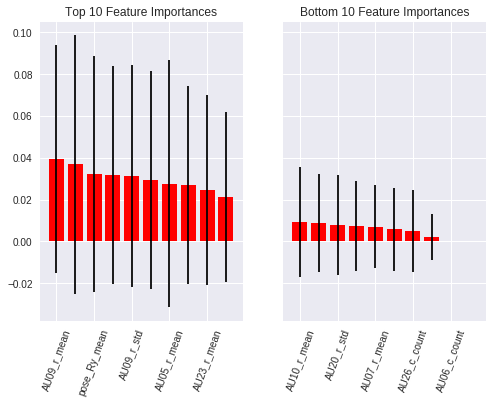

<Figure size 576x396 with 0 Axes>

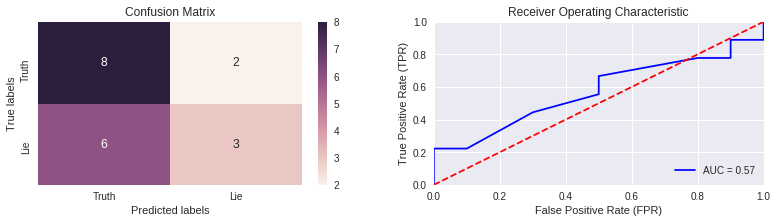

In [0]:
best_performing_model = {'name': 'Gradient Boosting',
                         'n_estimators': 50,
                         'model': GradientBoostingClassifier(n_estimators=50)}

model_dict = best_performing_model
model = model_dict['model']
model_name = model_dict['name']

model.fit(X_train,y_train)
y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)

# Plot feature importances
if model_name in ['Random Forest']:
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Plot the feature importances of the forest
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
  axes[0].set_title("Top 10 Feature Importances")
  axes[1].set_title("Bottom 10 Feature Importances")
  axes[0].bar(range(10), importances[indices[:10]],color="r", 
              yerr=std[indices[:10]], align="center")
  axes[1].bar(range(10), importances[indices[-10:]],color="r", 
              yerr=std[indices[-10:]], align="center")
  axes[0].set_xticklabels(X_train.iloc[:,indices[:10]].columns.tolist())
  axes[1].set_xticklabels(X_train.iloc[:,indices[-10:]].columns.tolist())
  for ax in axes:
    # Rotate the xticks on each axis
    plt.sca(ax)
    plt.xticks(rotation=70)
  plt.show()

# Get confusion matrix, FPRs, TPRs etc  
confusion_matrix = metrics.confusion_matrix(y_test, y_preds) 
FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
roc_auc = metrics.auc(FPRs, TPRs)

# Plot confusion matrix and ROC curves
plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,3))

sns.heatmap(confusion_matrix, annot=True, ax = axes[0], fmt='g')
axes[0].set_xlabel('Predicted labels'); axes[0].set_ylabel('True labels') 
axes[0].set_title('Confusion Matrix')
axes[0].set_xticklabels(['Truth', 'Lie']) # Maps 0 -> Truth, 1 -> Lie
axes[0].set_yticklabels(['Lie', 'Truth']) # Maps 0 -> Truth, 1 -> Lie

axes[1].set_title('Receiver Operating Characteristic')
axes[1].plot(FPRs, TPRs, 'b', label = 'AUC = %0.2f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1]); axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_xlabel('False Positive Rate (FPR)')

plt.show()

# Calculate the results dataframe with key metrics
acc = metrics.accuracy_score(y_test,y_preds)
results_df = pd.DataFrame()
results_df = results_df.append({'Model Name': model_name,
                                'n_estimators': model_dict['n_estimators'],
                                'Accuracy': round(acc,num_DP),
                                'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                                'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                                'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                                'AUC': round(roc_auc,num_DP),
                                'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                                'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                               },
                               ignore_index=True)

# Save the predictions!
# We save the probabilities rather than the prescribed classes
pd.DataFrame(model.predict_proba(X_test),
             index=y_test.index).to_csv('/content/gdrive/My Drive/UCL/Affective Computing/OpenFace_preds.csv')


results_df.set_index('Model Name', inplace=True)

In [0]:
results_df

,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall,n_estimators
Model Name,,,,,,,,
Gradient Boosting,0.572,0.579,0.429,0.429,0.4,0.6,0.333,50.0


## PCA/ tSNE Clustering Analysis

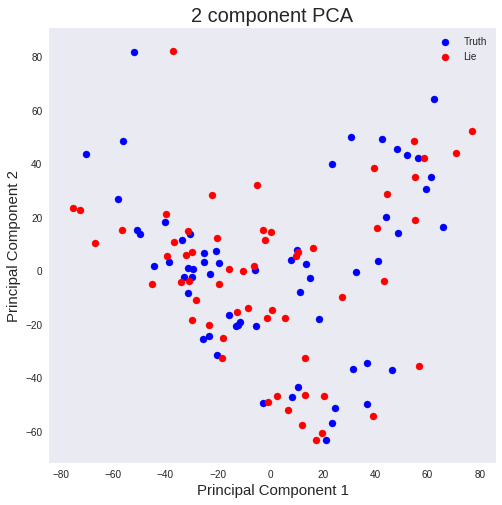

In [0]:
from sklearn.decomposition import PCA
# 2 component PCA plus visualisation
pca = PCA(n_components=2)
# Get the data in one format
X_all = pd.concat([X_train,X_test])
y_all = pd.concat([y_train,y_test])
principal_components = pca.fit_transform(X_all)
principal_df = pd.DataFrame(data = principal_components, index=X_all.index,
                            columns = ['Principal Component 1', 
                                       'Principal Component 2'])
final_df = pd.concat([principal_df, y_all], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = (final_df["label"] == target)
    ax.scatter(final_df.loc[indicesToKeep, 'Principal Component 1'],
               final_df.loc[indicesToKeep, 'Principal Component 2'],
               c = color, s = 50)
ax.legend(["Truth","Lie"])
ax.grid()    

In [0]:
for i in range(1,21):
    pca = PCA(n_components=i)
    pc = pca.fit(X_all)
    print("With", str(i),
          "principal component(s), the total explained variance is:",
          str(pc.explained_variance_ratio_.sum()))

With 1 principal component(s), the total explained variance is: 0.35252213640832875
With 2 principal component(s), the total explained variance is: 0.6190140644507778
With 3 principal component(s), the total explained variance is: 0.7324303186494634
With 4 principal component(s), the total explained variance is: 0.7901641075188667
With 5 principal component(s), the total explained variance is: 0.8361740494461908
With 6 principal component(s), the total explained variance is: 0.8653336044465384
With 7 principal component(s), the total explained variance is: 0.8908332669251434
With 8 principal component(s), the total explained variance is: 0.912590358957493
With 9 principal component(s), the total explained variance is: 0.9324651014129932
With 10 principal component(s), the total explained variance is: 0.9474997577088702
With 11 principal component(s), the total explained variance is: 0.9588969539649221
With 12 principal component(s), the total explained variance is: 0.9697151240816179
W

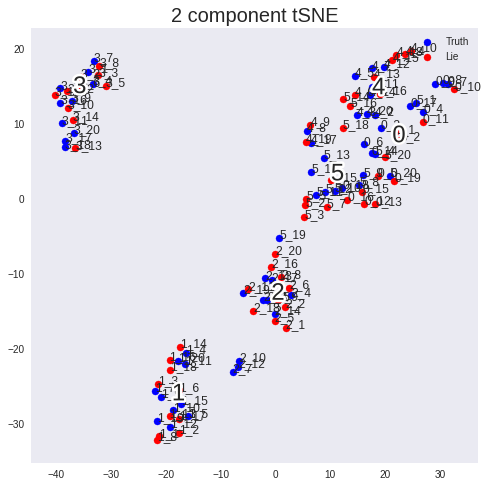

In [0]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

perplexity = 10 #@param
learning_rate = 50 #@param
# Get the data in one format
X_all = pd.concat([X_train,X_test])
y_all = pd.concat([y_train,y_test])
X_all = X_all.drop('4_1'); y_all = y_all.drop('4_1')
X_tsne = TSNE(learning_rate=learning_rate,
              perplexity=perplexity).fit_transform(X_all)
final_df = pd.concat([pd.DataFrame(X_tsne, columns=['Dimension 1','Dimension 2']),
                      y_all.reset_index()], axis=1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('2 component tSNE', fontsize = 20)
targets = [0,1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = (final_df["label"] == target)
    ax.scatter(final_df.loc[indicesToKeep, 'Dimension 1'],
               final_df.loc[indicesToKeep, 'Dimension 2'],
               c = color, s = 50)
# Annotate each point
for i, txt in enumerate(X_all.index.tolist()):
  ax.annotate(txt, (final_df.loc[:, 'Dimension 1'][i],
                    final_df.loc[:, 'Dimension 2'][i]))
  
for i in range(NUM_PERSONS):
  # Position of each label at median of data points.
  xtext, ytext = np.median(final_df[['Dimension 1','Dimension 2']]
                           [final_df['index'].str.startswith(str(i)).values],
                           axis=0)
  txt = ax.text(xtext, ytext, str(i), fontsize=24)
  txt.set_path_effects([
      PathEffects.Stroke(linewidth=5, foreground="w"),
      PathEffects.Normal()])
ax.legend(["Truth","Lie"])
ax.grid()  


### Model Fusion
We bring in the data from Empatica for each interaction and do a combined model fusion

In [0]:
with open('/content/gdrive/My Drive/UCL/Affective Computing/Data/Empatica Data/df_empatica_features.pickle', 'rb') as file:
    df_empatica_features = pickle.load(file)
# Hack together the indices so they match - different teams used different naming conventions!
df_empatica_features.loc[:,"new_index"] = [idx if int(idx.split("_")[0]) < 5 or int(idx.split("_")[-1]) < 6 else idx.split("_")[0] + "_" + str(int(idx.split("_")[-1]) + 1) for idx in df_empatica_features.index.tolist()]
df_empatica_features.set_index("new_index", inplace=True)
# Since p_id and ques are now in the index, we may drop them
y_all = df_empatica_features.iloc[:,2]
df_empatica_features.drop(columns=["ques","p_id"], inplace=True)
df_empatica_features.head()

,EDA_mean,EDA_std,EDA_first_diff,EDA_second_diff,EDA_first_diff_norm,time_count_norm
new_index,,,,,,
3_1,-1.076573,-4.899337,-5.948859,-5.548980,-1.049522,-0.672650
5_1,-1.456090,-5.528242,-6.048517,-6.279342,-0.520275,1.534373
4_2,0.540591,-3.148039,-4.268326,-4.250710,-1.120286,0.202255
0_3,1.717378,-1.446065,-3.261553,-2.761416,-1.815489,-0.672650
2_3,1.604142,-3.005482,-3.814139,-3.386100,-0.808656,-0.672650


### Feature level fusion

In [0]:
import itertools
#We want to iterate over preprocessing mode (p), features mode (f) + standardise
iterables = [ [0,1,2], [0,1,2], [False, True] ]

final_results_fused_dfs = []
for t in itertools.product(*iterables):
  # Set preprocessing mode, features mode and standardise mode
  p,f,standardise = t
  print('Performing Crossval with settings (p,f,standardise):',p,f,standardise)
  # Get the sets for these modes
  X_all,_,y_all,_ = build_sets(p,f,standardise)
  # Since we are fusing the features, add the empatica data
  X_all = pd.concat([X_all,df_empatica_features.loc[X_all.index]],
                    axis=1)
  results_dfs = []
  for person_left_out in range(NUM_PERSONS - 1): # Leave last person for testing
    X_train = X_all[~(X_all.index.str.startswith(str(person_left_out)))]
    X_test = X_all[(X_all.index.str.startswith(str(person_left_out)))]
    y_train = y_all.loc[X_train.index]
    y_test = y_all.loc[X_test.index]
    results_df = run_models(X_train,y_train,X_test,y_test,verbose=False)
    results_dfs.append(results_df)

  average_results_df = pd.concat(results_dfs).groupby("Model Name").mean()
  average_results_df.insert(0,"Standardise?",standardise)
  average_results_df.insert(0,"Features Mode", f)
  average_results_df.insert(0,"Preprocessing Mode", p)

  final_results_fused_dfs.append(average_results_df)

final_results_fused_df = pd.concat(final_results_fused_dfs)

Performing Crossval with settings (p,f,standardise): 0 0 False
Performing Crossval with settings (p,f,standardise): 0 0 True
Performing Crossval with settings (p,f,standardise): 0 1 False
Performing Crossval with settings (p,f,standardise): 0 1 True
Performing Crossval with settings (p,f,standardise): 0 2 False
Performing Crossval with settings (p,f,standardise): 0 2 True
Performing Crossval with settings (p,f,standardise): 1 0 False
Performing Crossval with settings (p,f,standardise): 1 0 True
Performing Crossval with settings (p,f,standardise): 1 1 False
Performing Crossval with settings (p,f,standardise): 1 1 True
Performing Crossval with settings (p,f,standardise): 1 2 False
Performing Crossval with settings (p,f,standardise): 1 2 True
Performing Crossval with settings (p,f,standardise): 2 0 False
Performing Crossval with settings (p,f,standardise): 2 0 True
Performing Crossval with settings (p,f,standardise): 2 1 False
Performing Crossval with settings (p,f,standardise): 2 1 True


In [0]:
final_results_fused_df.sort_values('AUC', ascending=False)

,Preprocessing Mode,Features Mode,Standardise?,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall
Model Name,,,,,,,,,,
Gradient Boosting,2,0,True,0.612,0.55,0.6042,0.335800,0.477600,0.5224,0.74
Gradient Boosting,1,1,True,0.598,0.56,0.6376,0.364800,0.420600,0.5794,0.78
Random Forest,2,1,False,0.585,0.55,0.4934,0.386800,0.557600,0.4424,0.58
Random Forest,0,2,True,0.581,0.59,0.5678,0.386600,0.396600,0.6034,0.62
K Nearest Neighbours (KNN),2,0,True,0.577,0.55,0.5990,0.499200,0.462400,0.5376,0.72
Gradient Boosting,0,0,True,0.570,0.52,0.6136,0.492200,0.492400,0.5076,0.80
Random Forest,2,2,False,0.560,0.55,0.5824,0.432200,0.464600,0.5354,0.68
Random Forest,0,1,False,0.545,0.55,0.4790,0.470600,0.366200,0.6338,0.44
Random Forest,1,0,False,0.543,0.51,0.4960,0.466600,0.494200,0.5058,0.54


In [0]:
# Now crossvalidate over the model hyperparameters
preprocess_mode = 1 #@param [0,1,2] {type:"raw"}
features_mode = 1 #@param [0,1,2] {type:"raw"}
standardise = False #@param {type:"boolean"}
# Get the sets for these modes
X_all,_,y_all,_ = build_sets(preprocess_mode,features_mode,standardise)
# Since we are fusing the features, add the empatica data
X_all = pd.concat([X_all,df_empatica_features.loc[X_all.index]],
                  axis=1)
results_dfs = []
for person_left_out in range(NUM_PERSONS - 1): # Leave last person for testing
  X_train = X_all[~(X_all.index.str.startswith(str(person_left_out)))]
  X_test = X_all[(X_all.index.str.startswith(str(person_left_out)))]
  y_train = y_all.loc[X_train.index]
  y_test = y_all.loc[X_test.index]
  results_df = run_models(X_train,y_train,X_test,y_test,verbose=False,crossval_mode=True)
  results_dfs.append(results_df)

average_results_df = pd.concat(results_dfs).groupby(["Model Name","n_estimators"]).mean()

In [0]:
average_results_df

AUC  Accuracy  F1 Score      FNR      FPR  \
Model Name        n_estimators                                                
Gradient Boosting 10.0          0.515      0.49    0.4676  0.50800  0.58780   
                  50.0          0.534      0.54    0.5604  0.43480  0.46840   
                  100.0         0.560      0.50    0.4864  0.45120  0.58840   
                  150.0         0.518      0.51    0.4852  0.45120  0.58000   
                  200.0         0.500      0.46    0.4494  0.51340  0.59840   
Random Forest     10.0          0.544      0.56    0.5388  0.46020  0.39540   
                  50.0          0.571      0.53    0.5464  0.48580  0.46020   
                  100.0         0.549      0.54    0.5672  0.41900  0.44300   
                  150.0         0.550      0.53    0.4958  0.54050  0.46375   
                  200.0         0.534      0.51    0.5122  0.38625  0.40240   

                                Precision  Recall  
Model Name        n_estimators                     
Gradient Boosting 10.0             0.4122    0.56  
                  50.0             0.5316    0.62  
                  100.0            0.4116    0.60  
                  150.0            0.4200    0.58  
                  200.0            0.4016    0.52  
Random Forest     10.0             0.6046    0.50  
                  50.0             0.5398    0.62  
                  100.0            0.5570    0.70  
                  150.0            0.4290    0.64  
                  200.0            0.5976    0.64

In [0]:
print(average_results_df.to_latex())

NameError: ignored

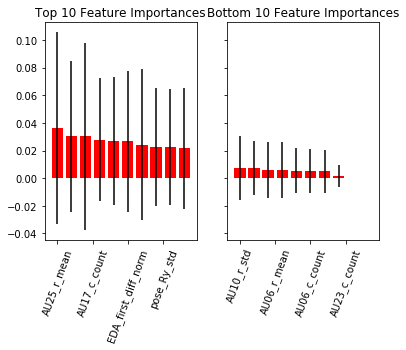

<Figure size 432x288 with 0 Axes>

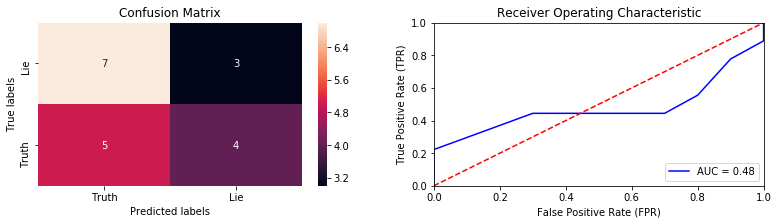

In [0]:
# Now do testing with model hyperparameter settings!
preprocess_mode = 1 #@param [0,1,2] {type:"raw"}
features_mode = 1 #@param [0,1,2] {type:"raw"}
standardise = False #@param {type:"boolean"}
X_train, X_test, y_train, y_test = build_sets(preprocess_mode,features_mode,standardise)
# Add in the empatica features, and run our models under setting chosen above
X_train = pd.concat([X_train,df_empatica_features.loc[X_train.index]],
                    axis=1)
X_test = pd.concat([X_test,df_empatica_features.loc[X_test.index]],
                   axis=1)
best_performing_model = {'name': 'Random Forest',
                         'n_estimators': 50,
                         'model': RandomForestClassifier(n_estimators=50)}

model_dict = best_performing_model
model = model_dict['model']
model_name = model_dict['name']

model.fit(X_train,y_train)
y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)

# Plot feature importances
if model_name in ['Random Forest', 'Gradient Boosting']:
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Plot the feature importances of the forest
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
  axes[0].set_title("Top 10 Feature Importances")
  axes[1].set_title("Bottom 10 Feature Importances")
  axes[0].bar(range(10), importances[indices[:10]],color="r", 
              yerr=std[indices[:10]], align="center")
  axes[1].bar(range(10), importances[indices[-10:]],color="r", 
              yerr=std[indices[-10:]], align="center")
  axes[0].set_xticklabels(X_train.iloc[:,indices[:10]].columns.tolist())
  axes[1].set_xticklabels(X_train.iloc[:,indices[-10:]].columns.tolist())
  for ax in axes:
    # Rotate the xticks on each axis
    plt.sca(ax)
    plt.xticks(rotation=70)
  plt.show()

# Get confusion matrix, FPRs, TPRs etc  
confusion_matrix = metrics.confusion_matrix(y_test, y_preds) 
FPRs, TPRs, thresholds = metrics.roc_curve(y_test, y_probs[:,1])
roc_auc = metrics.auc(FPRs, TPRs)

# Plot confusion matrix and ROC curves
plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,3))

sns.heatmap(confusion_matrix, annot=True, ax = axes[0], fmt='g')
axes[0].set_xlabel('Predicted labels'); axes[0].set_ylabel('True labels') 
axes[0].set_title('Confusion Matrix')
axes[0].set_xticklabels(['Truth', 'Lie']) # Maps 0 -> Truth, 1 -> Lie
axes[0].set_yticklabels(['Lie', 'Truth']) # Maps 0 -> Truth, 1 -> Lie

axes[1].set_title('Receiver Operating Characteristic')
axes[1].plot(FPRs, TPRs, 'b', label = 'AUC = %0.2f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1]); axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_xlabel('False Positive Rate (FPR)')

plt.show()

# Calculate the results dataframe with key metrics
acc = metrics.accuracy_score(y_test,y_preds)
results_df = pd.DataFrame()
results_df = results_df.append({'Model Name': model_name,
                                'n_estimators': model_dict['n_estimators'],
                                'Accuracy': round(acc,num_DP),
                                'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                                'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                                'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                                'AUC': round(roc_auc,num_DP),
                                'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                                'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                               },
                               ignore_index=True)

results_df.set_index('Model Name', inplace=True)

In [0]:
results_df

,AUC,Accuracy,F1 Score,FNR,FPR,Precision,Recall,n_estimators
Model Name,,,,,,,,
Random Forest,0.478,0.579,0.5,0.417,0.429,0.571,0.444,50.0


### Prediction Level Fusion
Combine the predictions on the test set of OpenFace and Empatica models $\mathcal{M}_o$ and $\mathcal{M}_e$ respectively, that yield predictions $p_o$ and $p_e$ respectively, then we can conclude on a given interaction that our prediction level fusion model predicts that the person is lying with probability $p = \alpha p_o + (1 - \alpha) p_e$ for some hyperparameter choice $\alpha$. This is our weighted average (note that $\alpha = \frac{1}{2}$ becomes a mean average).

<Figure size 432x288 with 0 Axes>

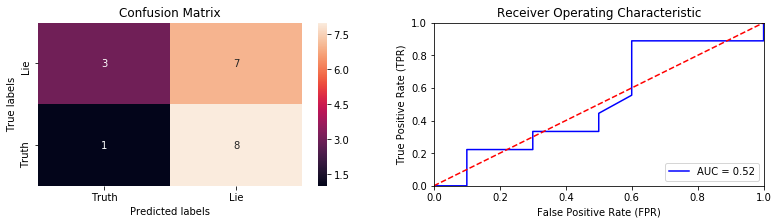

,AUC,Accuracy,Precision,Recall,F1 Score,FNR,FPR
0,0.517,0.579,0.533,0.889,0.667,0.25,0.467


In [0]:
# Get the predictions of the best OpenFace model and the best Empatica model
openface_preds = pd.DataFrame.from_csv('/content/gdrive/My Drive/UCL/Affective Computing/OpenFace_preds.csv')
empatica_preds = pd.DataFrame.from_csv('/content/gdrive/My Drive/UCL/Affective Computing/Empatica_preds.csv', index_col=1)
# Hack together the indices so they match - different teams used different naming conventions!
empatica_preds.loc[:,"new_index"] = [idx if int(idx.split("_")[-1]) < 6 else idx.split("_")[0] + "_" + str(int(idx.split("_")[-1]) + 1) for idx in empatica_preds.index.tolist()]
empatica_preds.set_index("new_index", inplace=True)
empatica_preds = empatica_preds.loc[openface_preds.index]
# The predictions have two columns, named 0 and 1 - probability of truth and lie
# We want to use the probability of lying, so column 1
alpha = 0.66 #@param {type:"slider", min:0, max:1, step:0.01}
fused_preds = alpha*openface_preds.iloc[:,-1] + (1-alpha)*empatica_preds.iloc[:,-1]

# Predict class 1 if fused preds > 50%
y_preds = (fused_preds > 0.5)
# Get confusion matrix, FPRs, TPRs etc  
confusion_matrix = metrics.confusion_matrix(y_test, y_preds) 
FPRs, TPRs, thresholds = metrics.roc_curve(y_test, fused_preds)
roc_auc = metrics.auc(FPRs, TPRs)

# Plot confusion matrix and ROC curves
plt.figure()
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(13,3))

sns.heatmap(confusion_matrix, annot=True, ax = axes[0], fmt='g')
axes[0].set_xlabel('Predicted labels'); axes[0].set_ylabel('True labels') 
axes[0].set_title('Confusion Matrix')
axes[0].set_xticklabels(['Truth', 'Lie']) # Maps 0 -> Truth, 1 -> Lie
axes[0].set_yticklabels(['Lie', 'Truth']) # Maps 0 -> Truth, 1 -> Lie

axes[1].set_title('Receiver Operating Characteristic')
axes[1].plot(FPRs, TPRs, 'b', label = 'AUC = %0.2f' % roc_auc)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].set_xlim([0, 1]); axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_xlabel('False Positive Rate (FPR)')

plt.show()
num_DP = 3
results_df = pd.DataFrame({'AUC': round(roc_auc,num_DP),
                           'Accuracy': round(metrics.accuracy_score(y_test,y_preds),num_DP),
                           'Precision': round(metrics.precision_score(y_test,y_preds),num_DP),
                           'Recall': round(metrics.recall_score(y_test,y_preds),num_DP),
                           'F1 Score': round(metrics.f1_score(y_test,y_preds),num_DP),
                           'FNR': round(confusion_matrix[1,0]/np.sum(confusion_matrix[:,0]) ,num_DP),
                           'FPR': round(confusion_matrix[0,1]/np.sum(confusion_matrix[:,1]) ,num_DP)
                          },index=[0])

results_df
